Probability of a girl birth given placenta previa (BDA3 p. 37). 437 girls and 543 boys have been observed. Calculate and plot the posterior distribution of the proportion of girls $\theta$, using uniform prior on $\theta$.

In [39]:
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt
%matplotlib inline

### Analysis using a uniform prior distribution

Given the uniform prior U(1,1), the posterior distribution is Beta(438, 544)

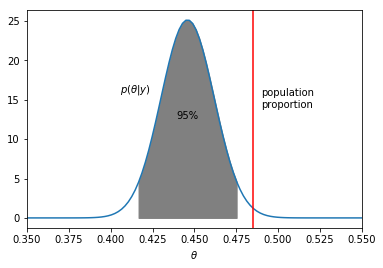

In [40]:
# create a grid 
x = np.linspace(0.35, 0.55, 100)

# Freeze the distribution and display the frozen pdf 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html
beta_dist = beta(438, 544)
prob_den = beta_dist.pdf(x)

plt.plot(x, prob_den)
plt.xlabel(r'$\theta$')

# annotate the line
plt.annotate(r'$p(\theta|y)$',(x[30] - 0.005, prob_den[40]))

# plot proportion of girl babies in general population as a vertical line
plt.axvline(0.485, color='r')
plt.annotate('population\nproportion', (0.485 + 0.005, 14))

# shade the 95% central posterior interval
idx_95_int = (x > beta_dist.ppf(0.025)) & (x < beta_dist.ppf(0.975))
plt.fill_between(x[idx_95_int], prob_den[idx_95_int], color='grey')
plt.text(beta_dist.median(), 0.5*np.max(prob_den), "95%", horizontalalignment='center')

# scale x-axis tightly to the data.
plt.autoscale(axis='x', tight=True);

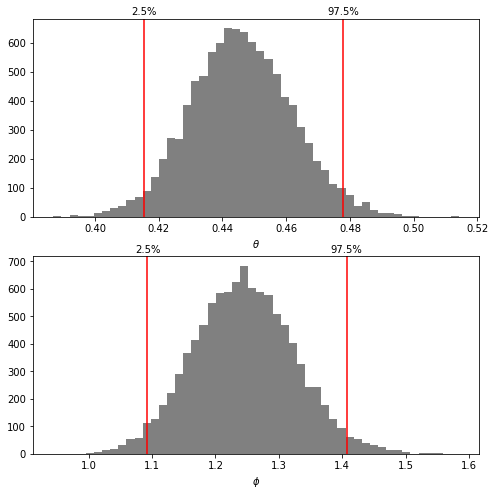

In [41]:
# draw n random samples from Beta(438,544)
n = 10000
theta_sample = beta.rvs(438, 544, size=n) 

# plot 2 subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# plot histogram
axes[0].hist(theta_sample, bins=50, color='grey')
# 2.5% and 97.5% sample percentile 
theta025, theta975 = np.percentile(theta_sample, [2.5, 97.5])
# draw lines for these
axes[0].axvline(theta025, color='red')
axes[0].axvline(theta975, color='red')
axes[0].text(
    theta025,
    axes[0].get_ylim()[1]+15,
    '2.5%',
    horizontalalignment='center'
)
axes[0].text(
    theta975,
    axes[0].get_ylim()[1]+15,
    '97.5%',
    horizontalalignment='center'
)
axes[0].set_xlabel(r'$\theta$')

# plot histogram for the logit transformed variable
phi_sample = (1-theta_sample)/theta_sample
axes[1].hist(phi_sample, bins=50, color='grey')
# 2.5% and 97.5% sample percentile 
phi025, phi975 = np.percentile(phi_sample, [2.5, 97.5])
# draw lines for these
axes[1].axvline(phi025, color='red')
axes[1].axvline(phi975, color='red')
axes[1].text(
    phi025,
    axes[1].get_ylim()[1]+15,
    '2.5%',
     horizontalalignment='center'
)
axes[1].text(
    phi975,
    axes[1].get_ylim()[1]+15,
    '97.5%',
    horizontalalignment='center'
)
axes[1].set_xlabel(r'$\phi$');

###  Analysis using different conjugate prior distributions

Parameters of the prior distribution: $\frac{\alpha}{\alpha + \beta} = 0.485$,$\alpha+\beta=\{2,5,10,20,100,200\}$

In [42]:
# arrays of different priors:
prior_sample_size = np.array([2,5,10,20,100,200])
a_prior = np.array([0.485 * i for i in prior_sample_size])
b_prior = np.array([(1-0.485) * i for i in prior_sample_size])
# corresponding posteriors with data (437,543)
a_post = 437 + a_prior
b_post = 543 + b_prior
# calculate prior and posterior densities
prior_den = beta.pdf(x, a_prior[:,np.newaxis], b_prior[:,np.newaxis])
post_den = beta.pdf(x, a_post[:,np.newaxis], b_post[:,np.newaxis])

n = len(prior_sample_size)
df = pd.DataFrame({'prior_sample_size':[None]*n, 'posterior_median':[None]*n, '95%_posterior_interval':[None]*n})
for i, s in enumerate(prior_sample_size):
    df.loc[i,'prior_sample_size'] = s
    beta_dist = beta(a_post[i], b_post[i])
    df.loc[i,'posterior_median'] = np.round(beta_dist.median(),3)
    df.loc[i,'95%_posterior_interval'] = np.round([beta_dist.ppf(0.025),beta_dist.ppf(0.975)], 3)
    
print(df)    

  prior_sample_size posterior_median 95%_posterior_interval
0                 2            0.446         [0.415, 0.477]
1                 5            0.446         [0.415, 0.477]
2                10            0.446         [0.415, 0.477]
3                20            0.447         [0.416, 0.478]
4               100             0.45          [0.42, 0.479]
5               200            0.453         [0.424, 0.481]


### Analysis using a non conjugate prior distribution

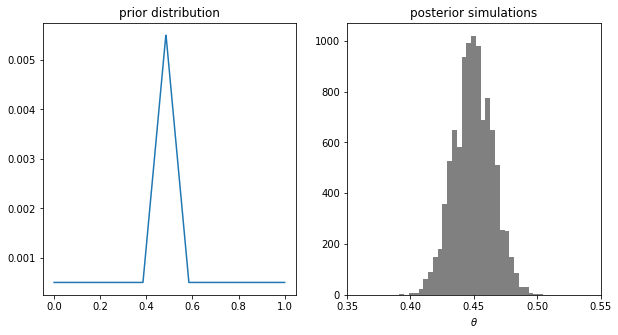

In [43]:
# grid
nx = 1000
x = np.linspace(0, 1, nx)

# compute density of non-conjugate prior 
prior_prob = np.ones(nx)
ascent = (0.385 <= x) & (x <= 0.485)
descent = (0.485 <= x) & (x <= 0.585)
peak = 11
prior_prob[ascent] = np.linspace(1, peak, np.sum(ascent))
prior_prob[descent] = np.linspace(peak, 1, np.sum(descent))
# normalize the prior
prior_prob /= np.sum(prior_prob)

# posterior
post_prob = beta.pdf(x, 437, 543)*prior_prob
post_prob /= np.sum(post_prob)
# cdf of prosterior
post_cdf = np.cumsum(post_prob)

# inverse-cdf sampling
n = 10000
r = np.random.rand(n)
# map each r into corresponding grid point x:
# [0, post_cdf[0]) map into x[0] and [post_cdf[i-1], post_cdf[i]), i>0, map into x[i]
rr = x[np.sum(post_cdf[:,np.newaxis] < r, axis=0)]

# plot
# plt.hist(rr, bins=30, color='grey')
# plt.title('posterior simulations')
# plt.xlabel(r'$\theta$')
# plt.xlim((0.35, 0.55));

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.plot(x, prior_prob)
ax1.set_title('prior distribution')
ax2.hist(rr, bins=30, color='grey')
ax2.set_title('posterior simulations')
ax2.set_xlabel(r'$\theta$')
ax2.set_xlim((0.35, 0.55));